# Predicting municipality healthcare costs in Finland

## Project outline

Finland has an extensive public healthcare system that is widely recognized to be one of the best in the world. In recent years, however, there have been issues with covering the costs and providing the necessary health care to all the regions. Our project focuses on analyzing and predicting healthcare costs of a municipality according to the following predictors:

* age distribution
* total population
* alcohol sales
* drug use offenses
* education level
* employment
* private healthcare visits
* flu vaccine coverage

We use data gathered by Finnish Health and Welfare Institute.

# Gathering the data

Our data was obtained from Finnish Institute of Health and Welfare (https://thl.fi/en/statistics-and-data/).

Our target variable is the net healthcare expenditure of a municipality's healthcare cost, measured in euros per capita. The predictors can be broadly classified into population-related and environmental. 

The population-related predictors include: percentages of population aged 0-18, 18-64 and 65 and over, percentage of population posessing a higher education qualifications, litres of pure alcohol sold in a year.

Challenges: It was hard to find data at times, since we needed the data to be grouped by municipality and between years 1993 and 2020. Sometimes data like that was not avaiable, or there was too little of it. Some data that interests us is dependent on questionnaires (like amount of exercise and other habits). This leads to a lot of data missing from cetrain municipalities, since not every municipality is going to gather that data. Data that we could not find per region: exercise, tobacco use, obesity. 

In [424]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold


In [425]:
# Total population by year and municipality
pop_total = pd.read_csv("data/pop_by_municipality.csv", sep=";", header=None, 
                         names=["category", "id", "municipality", "area_code", "gender", "year", "count", "pop_total"])

pop_total = pop_total[["municipality", "gender", "year", "pop_total"]]
pop_total = pop_total[np.where(pop_total["gender"] == "combined", True, False)]
pop_total = pop_total.drop(columns=["gender"])

# Total municipal health expenditure (euro per capita) by municipality and year
health_cost = pd.read_csv("data/health_per_capita_municipality.csv", sep=";", header=None, index_col=False,
                            names=["category", "id", "municipality", "area_code", "gender", "year", "health_cost"])

health_cost = health_cost[["municipality", "year", "health_cost"]]
data = pd.merge(pop_total, health_cost, how="inner", on=["year", "municipality"])

Above we have data on health expenditure by year and municipality, measured in euro per capita. Note that this includes environmental health care. The other data set contains total population by gender, year and municipality. From this data set we picked the combined population, both male and female, and joined with healthcare cost data by year and municipality. 

Since municipalities in Finland change from time to time, we needed to figure out what split is being used in our data. Count of municipalities:

In [426]:
data.municipality.unique().shape

(309,)

There seems to be 309 municipalities, which is the current number (relevant since 2021). Therefore we assume that the municipalities by which the data was compiled, is the current one. 

In [427]:
# Population structure as total numbers and percentages by municipality, year and ages
pop_structure = pd.read_csv("data/pop_structure_municipality.csv", sep=";", header=None).drop(columns=[1, 3, 7])
pop_structure.columns = ["category", "municipality", "gender", "year", "percent"]


# Create new columns male_0_18, male_18_64, male_65, female_0_18, female_18_64, female_65, combined_0_18, combined_18_64, combined_65
pop_structure["male_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["percent"], 0)

pop_structure["male_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["percent"], 0)

pop_structure["male_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "male"), pop_structure["percent"], 0)

pop_structure["female_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["percent"], 0)

pop_structure["female_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["percent"], 0)

pop_structure["female_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "female"), pop_structure["percent"], 0)

pop_structure["combined_0_18"] = np.where((pop_structure["category"] == "Population aged 0-18 as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["percent"], 0)

pop_structure["combined_18_64"] = np.where((pop_structure["category"] == "Population aged 18-64 as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["percent"], 0)

pop_structure["combined_65"] = np.where((pop_structure["category"] == "Population aged 65 and over as % of total population") 
                                      & (pop_structure["gender"] == "combined"), pop_structure["percent"], 0)

# Drop percentage, total, gender and category, group by year and region and obtain sum
pop_structure = pop_structure.drop(columns=["category", "gender", "percent"])
pop_structure = pop_structure.groupby(["municipality", "year"], as_index=False).sum()

# Merge with previous data
data = pd.merge(pop_structure, data, how="inner", on=["year", "municipality"])

Here we have population structure data. We chose to split the population by gender and ages 0-18, 18-64 and 65 and over. This would yield 9 new predictors: for each of the age categories we have men, women and combined population. First we created those columns and then grouped by region and year and summed the values to get all observations into one row. Note! values are percentages of total population.

Next we will merge some data on education and employment into the data frame.

In [428]:
# load data, drop unnecessary column 
edu = pd.read_csv("data/education_municipality.csv", sep=';', header=None).drop(columns=[0, 1, 3, 7])
edu.columns = ["municipality", "gender", "year", "higher_education"]

# pivot by gender
edu_pivot = edu.pivot_table(index=["municipality", "year"], columns="gender", values="higher_education").reset_index()
edu_pivot.rename(columns={"combined": "combined_higher_education", "female": "female_higher_education", "male": "male_higher_education"}, inplace=True)

# only select relevant columns
edu_pivot = edu_pivot[["municipality", "year", "male_higher_education", "female_higher_education", "combined_higher_education"]]

# merge with previous data
data = pd.merge(edu_pivot, data, how="inner", on=["year", "municipality"])

Next we merged education data with the current data. The data set contains population with higher education qualifications, as percentage of total population aged 20 and over by gender. Data source: Educational structure of population (Statistics Finland).

In [429]:
# alchohol data, as litres of pure alcohol sold per capita
alcohol = pd.read_csv("data/alcohol_sales_municipality.csv", sep=";", header=None).drop(columns=[0, 1, 3, 4, 7])
alcohol.columns = ["municipality", "year", "alcohol_sales"]

data = pd.merge(alcohol, data, how="inner", on=["year", "municipality"])

# statistic for drug offences per 1000 persons
drugs = pd.read_csv("data/drug_use_offences.csv", sep=";", header=None).drop(columns=[0, 1, 3, 4, 7])
drugs.columns = ["municipality", "year", "drug_offences"]

data = pd.merge(drugs, data, how="inner", on=["year", "municipality"])

Here we added data on alcohol sales measured in litres of pure alcohol sold in a year and wrote the data frame to csv file. Next, we are going to add employment data and information about visits to private healthcare.

In [430]:
# Add employment data
employment = pd.read_csv("data/employment.csv", header=None, sep=";").drop(columns=[0, 1, 3, 7])
employment.columns = ["municipality", "gender", "year", "employed"]

# pivot by gender
employment_pivot = employment.pivot_table(index=["municipality", "year"], columns="gender", values="employed").reset_index()
employment_pivot.rename(columns={"combined": "combined_employed", "female": "female_employed", "male": "male_employed"}, inplace=True)

# only select relevant columns
employment_pivot = employment_pivot[["municipality", "year", "male_employed", "female_employed", "combined_employed"]]

# merge with previous data
data = pd.merge(employment_pivot, data, how="inner", on=["year", "municipality"])

Here we have added the employment percentages for genders giving us three new predictors. 

In [431]:
private = pd.read_csv("data/visits_private.csv", header=None, sep=";").drop(columns=[0, 1, 3, 4, 7])
private.columns = ["municipality", "year", "visits_private"]

data = pd.merge(private, data, how="inner", on=["year", "municipality"])

Here we have added total visits to private healthcare visits. Next we will add the flu shot coverage of people aged 65 and over. 

The flu shot statistics is unfortunately in Finnish. We use columns under "Alue", which is the municipality and "Kattavuusprosentti", which is the vaccination coverage in percentages. Empty values are marked with "Ei tietoja". The statistics were only available by flu seasons from year 2012 to 2019. Since the flu season in Finland is about from November to March, we added the statistics from flu season 2012-2013 into 2013, from 2013-2014 flu season into 2014 etc. 

In [432]:
# read the files and add new column for year
flu_2013 = pd.read_csv("data/flu_2012_2013.csv", sep=";")
flu_2014 = pd.read_csv("data/flu_2013_2014.csv", sep=";")
flu_2015 = pd.read_csv("data/flu_2014_2015.csv", sep=";")
flu_2016 = pd.read_csv("data/flu_2015_2016.csv", sep=";")
flu_2017 = pd.read_csv("data/flu_2016_2017.csv", sep=";")
flu_2018 = pd.read_csv("data/flu_2017_2018.csv", sep=";")
flu_2019 = pd.read_csv("data/flu_2018_2019.csv", sep=";")
flu_2020 = pd.read_csv("data/flu_2019_2020.csv", sep=";")


flu_2013.insert(1, "year", np.full(flu_2013["Alue"].shape, 2013))
flu_2014.insert(1, "year", np.full(flu_2014["Alue"].shape, 2014))
flu_2015.insert(1, "year", np.full(flu_2015["Alue"].shape, 2015))
flu_2016.insert(1, "year", np.full(flu_2016["Alue"].shape, 2016))
flu_2017.insert(1, "year", np.full(flu_2017["Alue"].shape, 2017))
flu_2018.insert(1, "year", np.full(flu_2018["Alue"].shape, 2018))
flu_2019.insert(1, "year", np.full(flu_2019["Alue"].shape, 2019))
flu_2020.insert(1, "year", np.full(flu_2020["Alue"].shape, 2020))

# stack all data frames together
vaccination = pd.concat([flu_2013, flu_2014, flu_2015, flu_2016, flu_2017, flu_2018, flu_2019, flu_2020]).drop(columns=["Väestö", "Nimittäjä"])
vaccination = vaccination.rename(columns={"Alue": "municipality", "Kattavuusprosentti": "vaccine_coverage"})

data = pd.merge(vaccination, data, how="inner", on=["year", "municipality"]).replace(to_replace="Ei tietoja", value=np.nan)

In [433]:
data.to_csv("data/data_merged.csv", index=None)
print(data.shape)

(2360, 23)


Note! One municipality is completely missing from the drug offence statistic, so we are left with 308 municipalities after the merge. After the flu merge, we are left with 295 municipalities and 2360 observations. There are now 20 predictors. 

## Handling missing values

Our data is now a dataframe of shape

In [434]:
data = pd.read_csv("data/data_merged.csv", index_col=False)
print(data.shape)

(2360, 23)


We noticed that for some years and municipalities the healthcare cost that was recorded was negative or zero, which should not be possible. Therefore we decided to check all columns (except for year and municipality) for any strange values.  

In [435]:
# Check for NaN values
print("Any NaN values present:\n", data.drop(columns=['municipality', 'year']).isna().any())

# Check for negative values (outliers)
print("\nAny negative values present:\n", data.drop(columns=['municipality', 'year']).lt(0.0).any())

# Check for zeros
print("\nAny 0 present:\n", data.drop(columns=['municipality', 'year']).eq(0).any())

Any NaN values present:
 vaccine_coverage              True
visits_private               False
male_employed                False
female_employed              False
combined_employed            False
drug_offences                 True
alcohol_sales                False
male_higher_education        False
female_higher_education      False
combined_higher_education    False
male_0_18                    False
male_18_64                   False
male_65                      False
female_0_18                  False
female_18_64                 False
female_65                    False
combined_0_18                False
combined_18_64               False
combined_65                  False
pop_total                    False
health_cost                  False
dtype: bool

Any negative values present:
 vaccine_coverage             False
visits_private               False
male_employed                False
female_employed              False
combined_employed            False
drug_offences         

There are missing values in the "drug_offences" and "vaccine_coverage" columns and negative values in the "health_cost" column. There are also zeros in "drug_offences" and "health_cost" columns. The negative values are probably recorded incorrectly. Zeros can be possible values, although in the case of healthcare costs it is unlikely. We processed the data in the following way:

- For "drug_offences" colum we filled NaN values with the mean and kept the zero values.

- For "health_cost" column we dropped all the municipalities in Ahvenanmaa.

- For "vaccine_coverage" column we decided to drop the rows with missing values. The reasoning behind this was that the vaccination status is not very linear, so it's difficult to interpolate. The average standard deviation of vaccination status accross all municipalities is 6.4 percentage units.

In [436]:
vacc_data = data[["municipality", "vaccine_coverage"]].groupby(["municipality"])

vacc_data.std().mean()

vaccine_coverage    6.395765
dtype: float64

In [437]:
# Fill NaN values in 'drug_offences' with the mean for each municipality
data['drug_offences'] = data.groupby('municipality')['drug_offences'].transform(lambda x: x.fillna(x.mean()) if not x.isnull().all() else 0)

# Replace negative values in 'health_cost' with the median excluding negative values
data['cost_median'] = data.groupby('municipality')['health_cost'].transform(lambda x: x[x >= 0].median())
data['health_cost'] = np.where(data['health_cost'] < 0, data['cost_median'], data['health_cost'])
data.drop(columns=['cost_median'], inplace=True)

# Format the output to four decimal places
data['drug_offences'] = data['drug_offences'].map('{:.4f}'.format).astype(float)

# Drop observations, where there is no vaccine information.
data = data.dropna()

# Print the rows with healthcare cost of zero
print(data[data["health_cost"] == 0].municipality.unique())

ahvenanmaa_municipalities = ["Finström", "Geta", "Hammarland", "Jomala", 
                             "Saltvik", "Sund", "Eckerö", "Kumlinge", 
                             "Lemland", "Lumparland", "Kökar", "Sottunga",
                             "Brändö", "Föglö", "Vårdö"]

data = data[~data["municipality"].isin(ahvenanmaa_municipalities)]

['Kumlinge' 'Kökar' 'Sottunga']


It seems only three municipalities have healthcare costs of zero, and they are all located in the region of Ahvenanmaa, which is an autonomous region. It is probable that the data recorded is not accurate, since it is unlikely the healthcare costs for any municipality would be zero for a whole year. We are considering removing the data points as outliers. 

In [438]:
data.to_csv("data/data_clean.csv", index=False)

data.head()

,municipality,year,vaccine_coverage,visits_private,male_employed,female_employed,combined_employed,drug_offences,alcohol_sales,male_higher_education,...,male_18_64,male_65,female_0_18,female_18_64,female_65,combined_0_18,combined_18_64,combined_65,pop_total,health_cost
0,Huittinen,2013,23.6,4728,43.1,39.2,41.1,0.8,9.1,16.4,...,59.7,21.1,17.7,55.0,28.6,19.0,57.3,24.9,10543,1888.1
2,Hyrynsalmi,2013,40.1,1295,32.2,30.8,31.5,0.0,10.2,12.5,...,60.9,26.4,13.7,51.7,36.5,14.0,56.4,31.3,2565,2400.8
3,Hyvinkää,2013,44.0,29592,45.4,43.6,44.5,2.4,6.6,26.1,...,63.4,15.5,20.5,59.7,21.1,21.5,61.5,18.4,46188,1862.8
4,Hämeenkyrö,2013,31.4,6261,40.4,39.5,39.9,1.2,7.7,17.9,...,59.4,18.0,21.6,56.6,23.1,22.7,58.0,20.5,10582,1781.8
5,Hämeenlinna,2013,47.0,42645,42.7,41.1,41.8,2.0,8.6,26.9,...,61.3,19.1,18.8,57.4,25.1,19.9,59.2,22.2,67806,1698.3


Our final data set has 17 predictors and 2293 observations. Next we will move on to EDA.

## Exploratory data analysis

We are most interested in the following questions about the data: 

* Is gender significant for the predictors that are gender-specific, or can the gendered columns be dropped?
* What is the correlation between the predictors?
* Which predictors explain the most of the target variable's variance?

We have three predictors which are gendered: education, age distribution and employment. We would like to see if the gender is significant enough in explaining the target variable, or could we only use the genders combined columns for the result. 

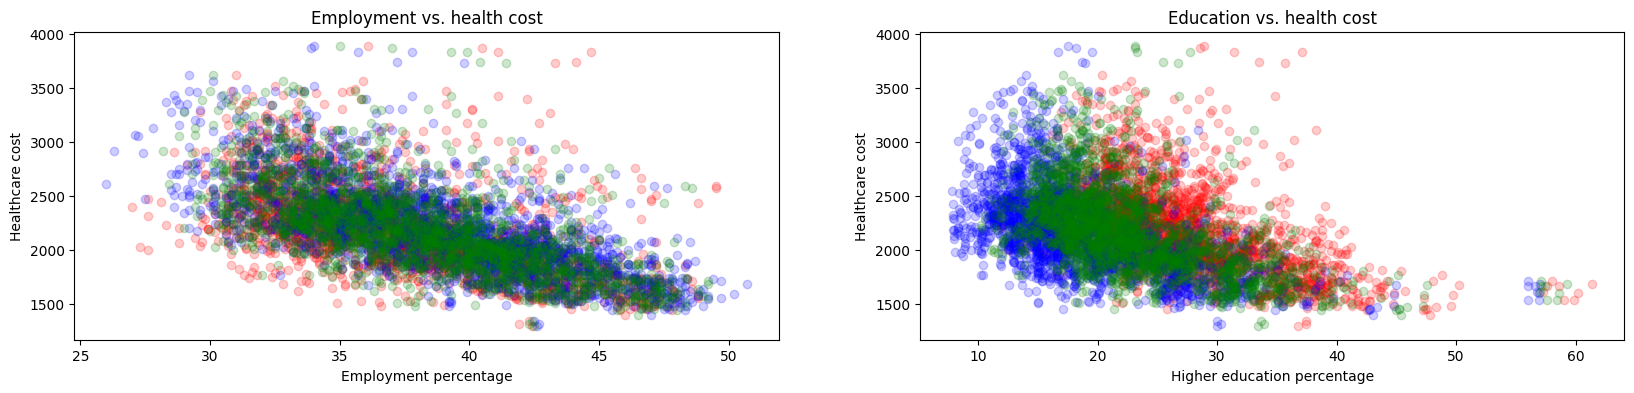

In [439]:
df = pd.read_csv("data/data_clean.csv")
df_employed = df[["male_employed", "female_employed", "combined_employed", "health_cost"]]
df_education = df[["male_higher_education", "female_higher_education", "combined_higher_education", "health_cost"]]

fig, axs = plt.subplots(1, 2, figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.scatter(df_employed['female_employed'], df_employed['health_cost'], color='red', alpha=0.2, label="Female")    
plt.scatter(df_employed['male_employed'], df_employed['health_cost'], color='blue', alpha=0.2, label="Male")    
plt.scatter(df_employed['combined_employed'], df_employed['health_cost'], color='green', alpha=0.2, label="Combined")
plt.xlabel("Employment percentage")
plt.ylabel("Healthcare cost")
plt.title("Employment vs. health cost")

plt.subplot(1, 2, 2)
plt.scatter(df_education['female_higher_education'], df_education['health_cost'], color='red', alpha=0.2, label="Female")    
plt.scatter(df_education['male_higher_education'], df_education['health_cost'], color='blue', alpha=0.2, label="Male")    
plt.scatter(df_education['combined_higher_education'], df_education['health_cost'], color='green', alpha=0.2, label="Combined")
plt.xlabel("Higher education percentage")
plt.ylabel("Healthcare cost")
plt.title("Education vs. health cost")

plt.savefig('images/education_employment.jpg')

It seems that the combined data represents the trend well enough. We can print the mean and standard deviation and repeat this to the other predictors too. 

In [440]:
print(f"Female employment average {df_employed['female_employed'].mean():.2f} and standard deviation {df_employed['female_employed'].std():.2f}")
print(f"Male employment average {df_employed['male_employed'].mean():.2f} and standard deviation {df_employed['male_employed'].std():.2f}")
print(f"Combined employment average {df_employed['combined_employed'].mean():.2f} and standard deviation {df_employed['combined_employed'].std():.2f}")

Female employment average 37.46 and standard deviation 4.35
Male employment average 38.71 and standard deviation 4.59
Combined employment average 38.08 and standard deviation 4.34


In [441]:
print(f"Female higher education average {df_education['female_higher_education'].mean():.2f} and standard deviation {df_education['female_higher_education'].std():.2f}")
print(f"Male higher education average {df_education['male_higher_education'].mean():.2f} and standard deviation {df_education['male_higher_education'].std():.2f}")
print(f"Combined higher education average {df_education['combined_higher_education'].mean():.2f} and standard deviation {df_education['combined_higher_education'].std():.2f}")

Female higher education average 27.09 and standard deviation 6.47
Male higher education average 18.59 and standard deviation 6.57
Combined higher education average 22.80 and standard deviation 6.49


We will go ahead and discard the gendered columns from employment, but keep them for higher education data, since the differences there are more significant. 

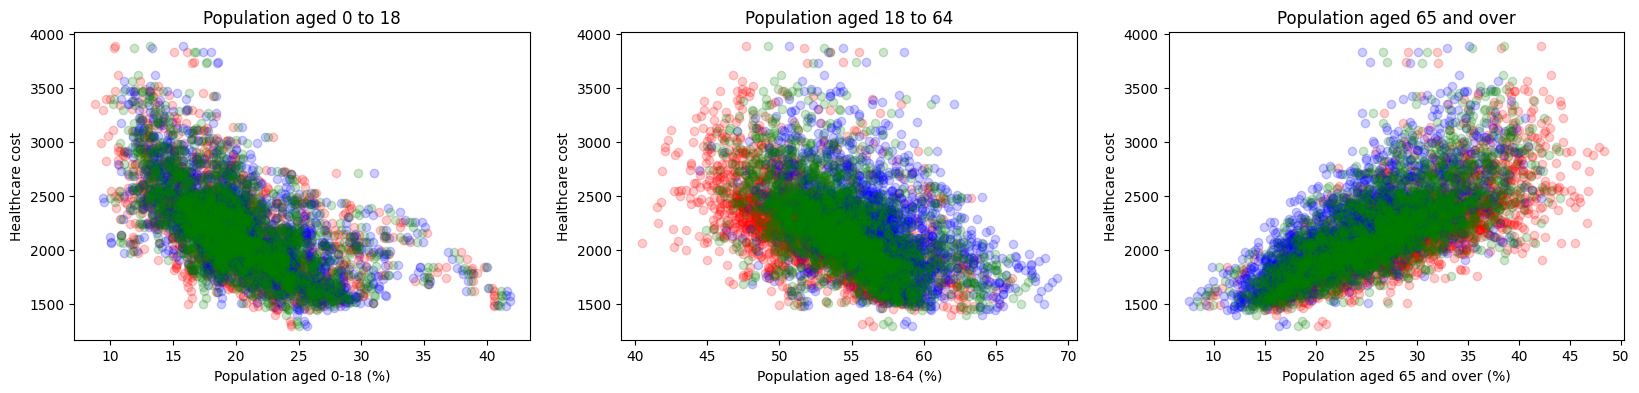

In [442]:
df_age = df[["male_0_18","female_0_18","combined_0_18",
             "male_18_64","female_18_64","combined_18_64",
             "male_65","female_65","combined_65", "health_cost"]]

fig, axs = plt.subplots(1, 3, figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.scatter(df_age['female_0_18'], df_age['health_cost'], color='red', alpha=0.2, label="Female")
plt.scatter(df_age['male_0_18'], df_age['health_cost'], color='blue', alpha=0.2, label="Male")    
plt.scatter(df_age['combined_0_18'], df_age['health_cost'], color='green', alpha=0.2, label="Combined")
plt.xlabel("Population aged 0-18 (%)")
plt.ylabel("Healthcare cost")
plt.title("Population aged 0 to 18")

plt.subplot(1, 3, 2)
plt.scatter(df_age['female_18_64'], df_age['health_cost'], color='red', alpha=0.2, label="Female")
plt.scatter(df_age['male_18_64'], df_age['health_cost'], color='blue', alpha=0.2, label="Male")    
plt.scatter(df_age['combined_18_64'], df_age['health_cost'], color='green', alpha=0.2, label="Combined")
plt.xlabel("Population aged 18-64 (%)")
plt.ylabel("Healthcare cost")
plt.title("Population aged 18 to 64")

plt.subplot(1, 3, 3)
plt.scatter(df_age['female_65'], df_age['health_cost'], color='red', alpha=0.2, label="Female")
plt.scatter(df_age['male_65'], df_age['health_cost'], color='blue', alpha=0.2, label="Male")    
plt.scatter(df_age['combined_65'], df_age['health_cost'], color='green', alpha=0.2, label="Combined")
plt.xlabel("Population aged 65 and over (%)")
plt.ylabel("Healthcare cost")
plt.title("Population aged 65 and over")

plt.savefig('images/pop_distribution.jpg')

The combined column seems to represent the 0-18 and 65 and over population well. However, we will keep the gendered columns for the population aged 18 to 64. 

In [443]:
predictors = ["combined_0_18", "combined_18_64", "combined_65", 
              "vaccine_coverage", "combined_employed", 
              "alcohol_sales", "drug_offences", "visits_private",
              "combined_higher_education", "pop_total", "health_cost"]

df = df[predictors]

df.head()

,combined_0_18,combined_18_64,combined_65,vaccine_coverage,combined_employed,alcohol_sales,drug_offences,visits_private,combined_higher_education,pop_total,health_cost
0,19.0,57.3,24.9,23.6,41.1,9.1,0.8,4728,21.2,10543,1888.1
1,14.0,56.4,31.3,40.1,31.5,10.2,0.0,1295,14.2,2565,2400.8
2,21.5,61.5,18.4,44.0,44.5,6.6,2.4,29592,29.1,46188,1862.8
3,22.7,58.0,20.5,31.4,39.9,7.7,1.2,6261,21.9,10582,1781.8
4,19.9,59.2,22.2,47.0,41.8,8.6,2.0,42645,29.9,67806,1698.3


Now we have 11 predictors. Let's look at the covariances next.

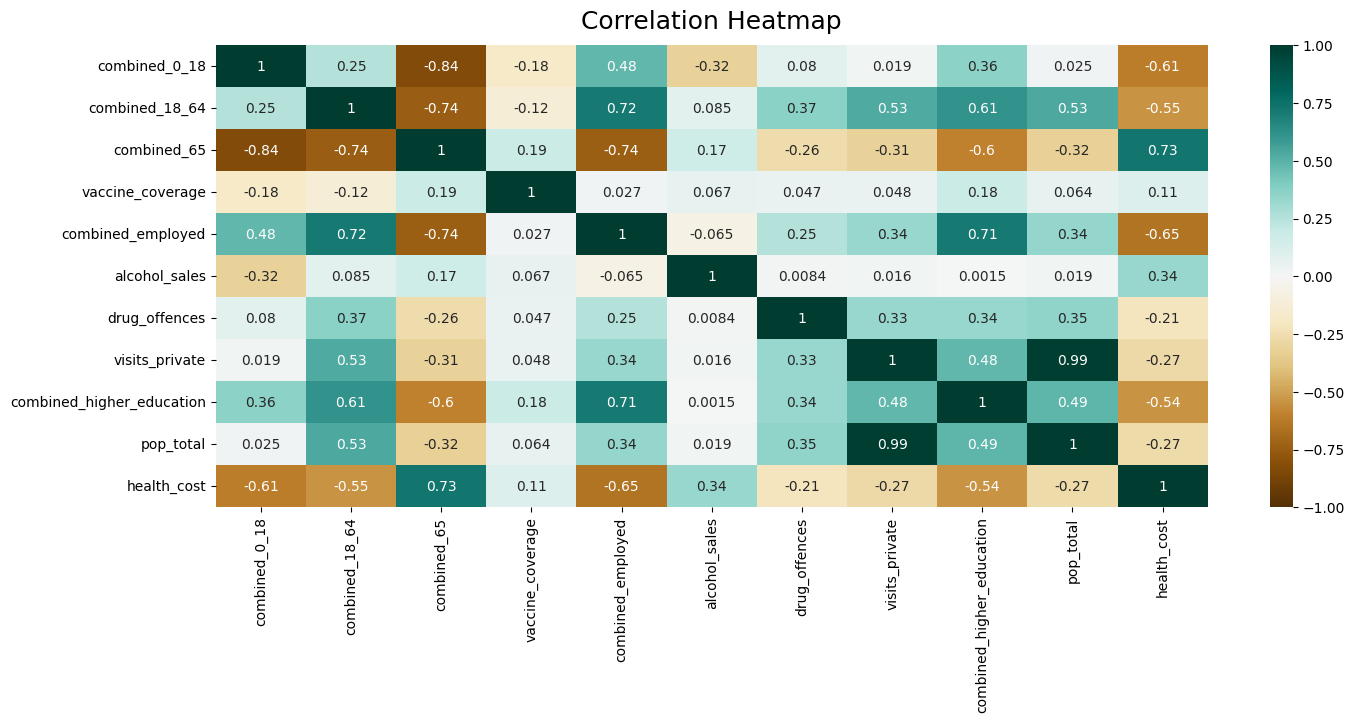

In [444]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

plt.savefig('images/heatmap.png', dpi=300, bbox_inches='tight')

We notice the following correlations:
- The health cost is negatively correlated with percentage of employed citizens. 
- The number of people aged 65 and over does raise healthcare costs. 
- The number of female citizens aged 18 to 64 raises employment more than the male counterpart. 
- Alcohol sales raise healthcare costs. 

We will plot the relationship between health cost and employment. 

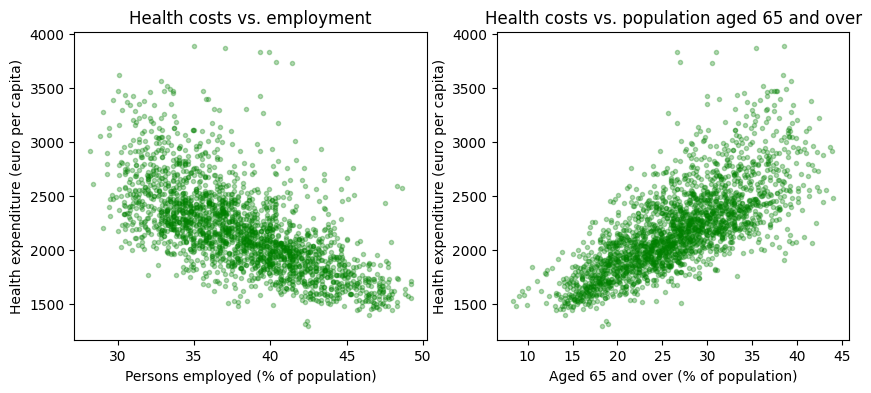

In [445]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(df["combined_employed"], data["health_cost"], alpha=0.3, color="green", marker=".")
plt.xlabel("Persons employed (% of population)")
plt.ylabel("Health expenditure (euro per capita)")
plt.title("Health costs vs. employment")

plt.subplot(1, 2, 2)
plt.scatter(data["combined_65"], data["health_cost"], alpha=0.3, color="green", marker=".")
plt.xlabel("Aged 65 and over (% of population)")
plt.ylabel("Health expenditure (euro per capita)")
plt.title("Health costs vs. population aged 65 and over")

plt.savefig('images/health_scatters.png')

The relationship is fairly linear.

### Principal Component Analysis

We will try to reduce the feature space into lower dimensions. 

Here is a map of health expenditure visualized on the map of Finland (some Swedish regions have different names so need to be joined separately):

Scatter plot between higher education and health expenditure:

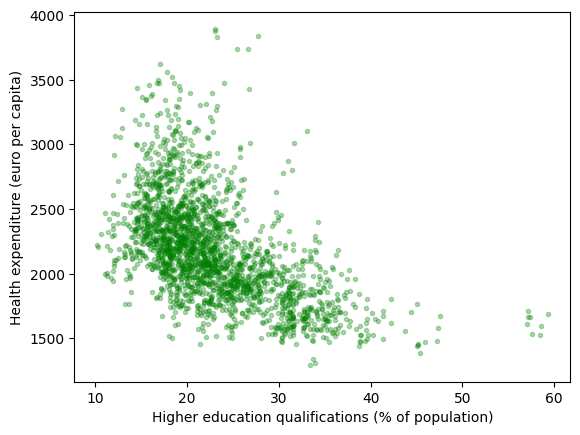

In [446]:
plt.scatter(data["combined_higher_education"], data["health_cost"], alpha=0.3, color="green", marker=".")
plt.xlabel("Higher education qualifications (% of population)")
plt.ylabel("Health expenditure (euro per capita)")
plt.show()

### Principal Component Analysis

Next we will try to reduce the feature space for plotting purposes. 

Variance explained by principle components [0.42390155 0.18627651]


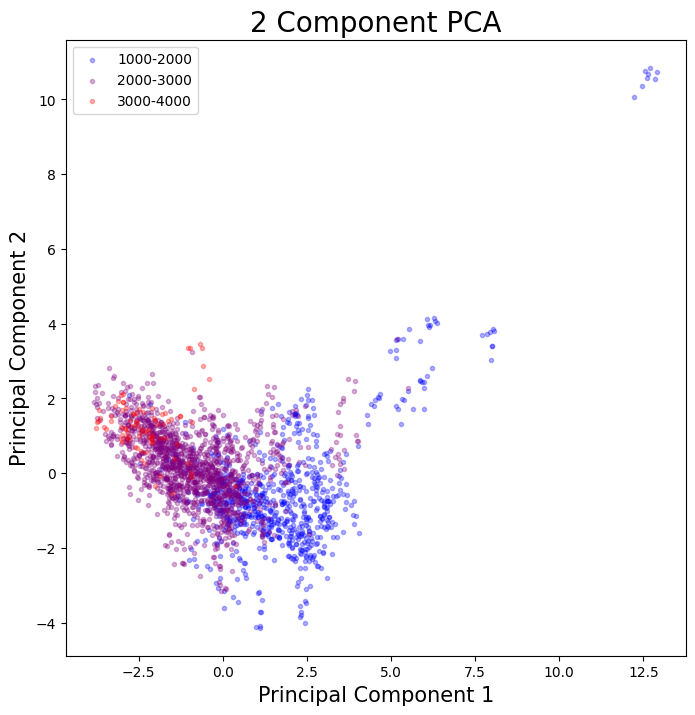

In [447]:
df = pd.read_csv("data/data_clean.csv")[predictors]

# pick feature values
feature_values = df.iloc[:, :-1].values

# pick target values and replace them with ranges
target_df = df.loc[:, ['health_cost']]
target_df = target_df.mask((target_df["health_cost"] >= 1000) & (target_df["health_cost"] < 2000), 0)
target_df = target_df.mask((target_df["health_cost"] >= 2000) & (target_df["health_cost"] < 3000), 1)
target_df = target_df.mask((target_df["health_cost"] >= 3000) & (target_df["health_cost"] < 4000), 2)
target_df = target_df.replace(0, "1000-2000")
target_df = target_df.replace(1, "2000-3000")
target_df = target_df.replace(2, "3000-4000")
target_values = target_df.values

# Scale features
scaler = StandardScaler()
feature_values = StandardScaler().fit_transform(feature_values)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(feature_values)

principal_df = pd.DataFrame(data=principal_components, columns = ['pca_1', 'pca_2'])
principal_df = pd.concat([principal_df, target_df[['health_cost']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['1000-2000', '2000-3000', '3000-4000']
colors = ['blue', 'purple', 'red']
for target, color in zip(targets, colors):
    indicesToKeep = principal_df['health_cost'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'pca_1'],
               principal_df.loc[indicesToKeep, 'pca_2'],
               c = color,
               marker=".", alpha=0.3)
ax.legend(targets)

plt.savefig('images/pca.png')

print(f"Variance explained by principle components {pca.explained_variance_ratio_}")

In [448]:
pca = PCA(n_components = 0.95)
pca.fit(feature_values)
reduced = pca.transform(feature_values)
print('Original Dimensions: ',feature_values.shape)  #14
print('Reduced Dimensions: ',reduced.shape) #11

Original Dimensions:  (2218, 10)
Reduced Dimensions:  (2218, 7)


## The model

Firstly, we use Ordinary Least Squares (OLS) regression model. For predictiors including male, female and combined data, we use only combined data, which means we don't use gender-specific predictors.

In [449]:
df = pd.read_csv("data/data_clean.csv")

# Standardize numerical data, use predictors that are not gender-specific
scaler = StandardScaler()
numerical_features = ["vaccine_coverage","visits_private", 
                      "combined_employed", 
                      "drug_offences","alcohol_sales", 
                      "combined_higher_education",
                      "combined_18_64",
                      "combined_0_18","combined_65",
                      "pop_total"]

df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Prepare features and target variable
X = df[numerical_features]
y = df['health_cost']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Add a constant to the model (intercept) for both training and test sets
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Predictions
y_pred = results.predict(X_test_sm)  

# Print out the statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            health_cost   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     297.8
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:41:56   Log-Likelihood:                -12259.
No. Observations:                1774   AIC:                         2.454e+04
Df Residuals:                    1763   BIC:                         2.460e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

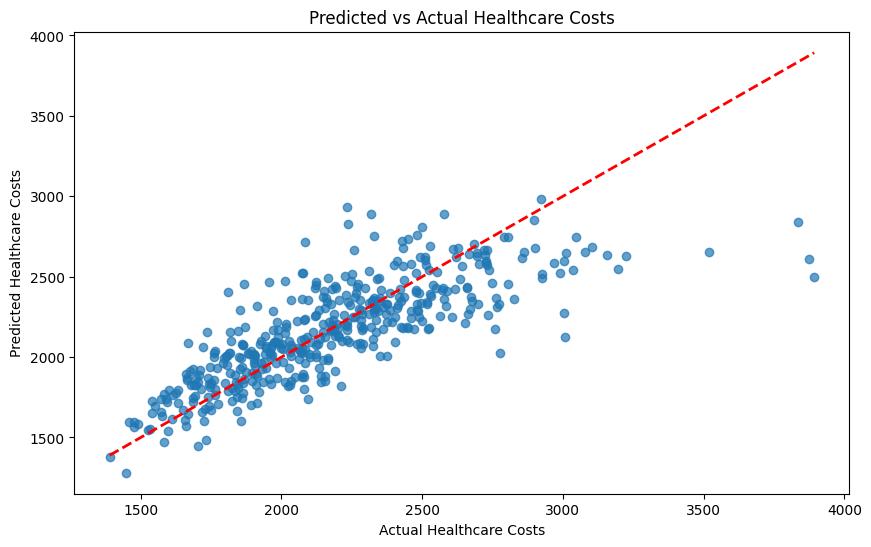

In [450]:
# Scatter plot of predicted vs actual healthcare costs
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
# Plot a 45-degree line (the y-coordinates are the same as the x-coordinates)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')  
plt.title('Predicted vs Actual Healthcare Costs')
plt.xlabel('Actual Healthcare Costs')
plt.ylabel('Predicted Healthcare Costs')
plt.show()

The reference line in the scatter plot that represents the ideal scenario where the predicted values perfectly match the actual values. The better the predictive performance of the model, the more points will lie on the line. Points above the line indicate over-predictions, while points below indicate under-predictions.

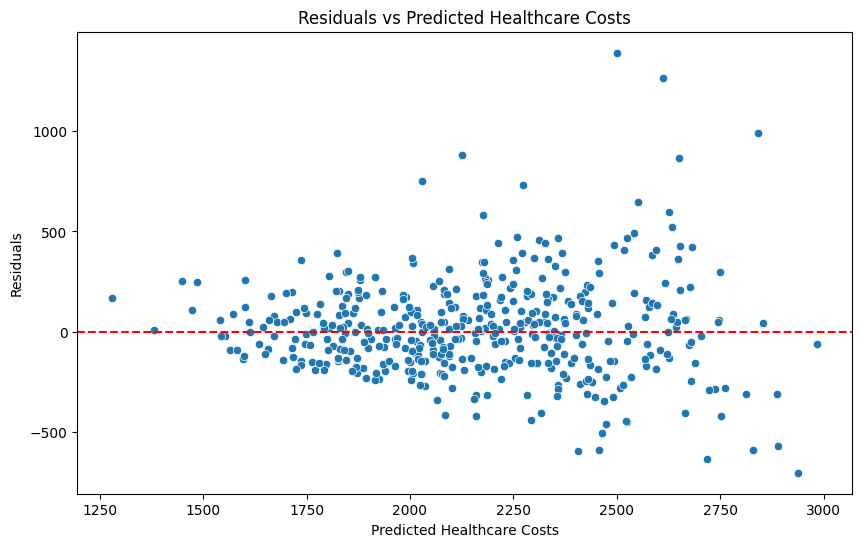

In [451]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Healthcare Costs')
plt.xlabel('Predicted Healthcare Costs')
plt.ylabel('Residuals')
plt.show()

The residual is the difference between the actual value and the predicted value. The residuals are randomly scattered around the horizontal line (y=0), it suggests that the model is appropriate and that the assumptions of linear regression are likely met.

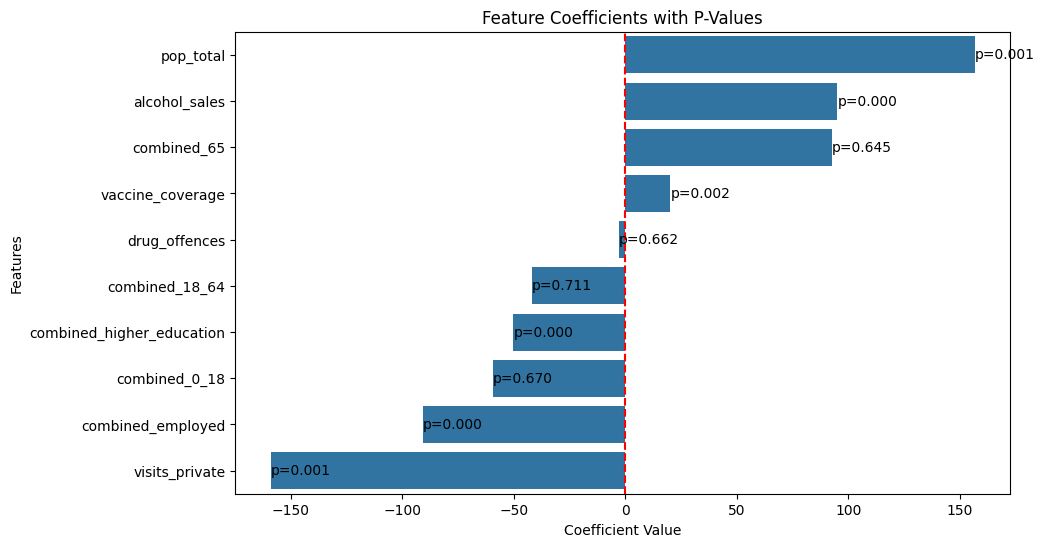

In [452]:
# Plot coefficients and p-values
coefficients = results.params[1:]  # Exclude the intercept
p_values = results.pvalues[1:]  # Exclude the intercept p-value

# Create a DataFrame for better handling
coef_df = pd.DataFrame({
    'Feature': numerical_features,
    'Coefficient': coefficients,
    'P-Value': p_values
})

# Sort the DataFrame by P-Values for better visualization
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, legend=False)
plt.title('Feature Coefficients with P-Values')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.axvline(0, color='red', linestyle='--')  # Add a vertical line at x=0 for reference

# Annotate the bars with p-values
for index, row in coef_df.iterrows():
    plt.text(row['Coefficient'], index, f'p={row["P-Value"]:.3f}', 
             color='black', ha='left', va='center')

plt.show()

A bigger coefficient (either positive or negative) suggests a stronger influence of that feature on the target variable. When P-Value < 0.05, generally considered statistically significant. Features with high p-values may be considered less important or irrelevant in the context of the model. So features with both large coefficients and low p-values are likely to be the most impactful in predicting the target variable. 

Then we use K-fold cross-validation to assess the OLS regression model's performance.

In [453]:
# Define a custom scoring function for statsmodels
def ols_cross_val_score(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=41)
    mse_scores = []
    r2_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Add constant to the model (intercept)
        X_train_sm = sm.add_constant(X_train)
        X_test_sm = sm.add_constant(X_test)

        # Fit OLS model
        model = sm.OLS(y_train, X_train_sm).fit()

        # Predict and calculate Mean Squared Error (MSE) and R-squared
        y_pred = model.predict(X_test_sm)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
    
    # Calculate average MSE across all folds
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    return avg_mse, avg_r2

# Run cross-validation on the OLS model
avg_mse, avg_r2 = ols_cross_val_score(X, y, n_splits=5)
print(f"Average MSE across 5 folds: {avg_mse}")
print(f"Average R-squared across 5 folds: {avg_r2}")

Average MSE across 5 folds: 59713.163332606935
Average R-squared across 5 folds: 0.6206000022019352


## Comparing different models

From the OLS regression model, we can see relationships between variables. Since our project involves both feature selection and prediction, now we use Lasso regression due to its ability to regularize and perform automatic feature selection.

In [454]:
# Standardize numerical data
scaler = StandardScaler()
numerical_features = ["vaccine_coverage", "visits_private", 
                      "combined_employed", "drug_offences", 
                      "alcohol_sales", "combined_higher_education",
                      "combined_18_64", "combined_0_18", 
                      "combined_65", "pop_total"]

df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Prepare features and target variable
X = df[numerical_features]
y = df['health_cost']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Initialize and fit Lasso model with cross-validation
lasso_cv = LassoCV(cv=5, random_state=41)
lasso_cv.fit(X_train, y_train)

# Predictions
y_pred = lasso_cv.predict(X_test)

# Model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimal alpha (regularization strength): {lasso_cv.alpha_}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Feature coefficients
print("\nCoefficients of the selected features:")
coefficients = pd.Series(lasso_cv.coef_, index=numerical_features)
print(coefficients[coefficients != 0].sort_values(ascending=False))


Optimal alpha (regularization strength): 0.29039116092528355
Mean Squared Error: 59325.19166035047
R-squared: 0.6200270931615228

Coefficients of the selected features:
pop_total                    118.167432
combined_65                  105.224280
alcohol_sales                 94.897333
vaccine_coverage              20.546253
drug_offences                 -1.796767
combined_18_64               -34.180559
combined_higher_education    -49.919933
combined_0_18                -50.057102
combined_employed            -91.213557
visits_private              -121.116870
dtype: float64


We use Lasso regression with cross-validation (5-fold here) for optimal regularization (alpha) tuning. Computes Mean Squared Error (MSE) and R-squared to assess prediction accuracy. Outputs only non-zero coefficients, indicating the predictors that significantly impact healthcare costs after regularization.

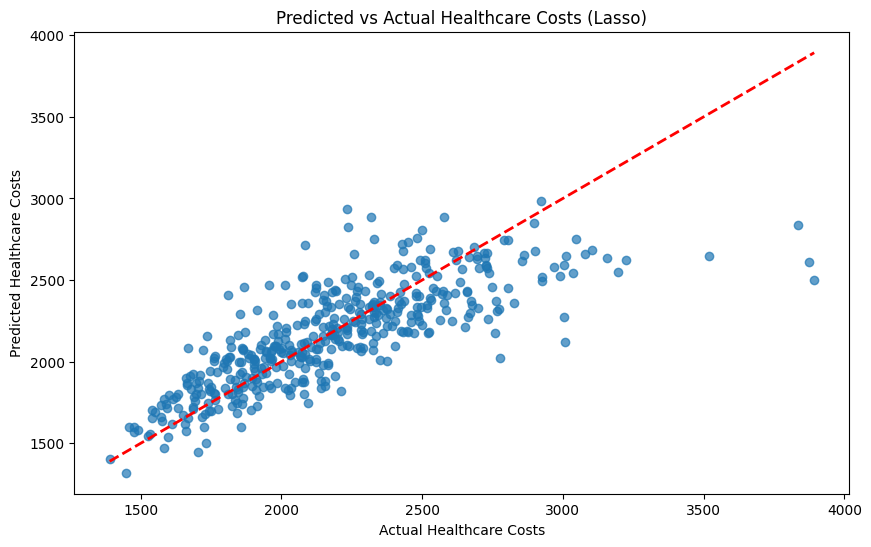

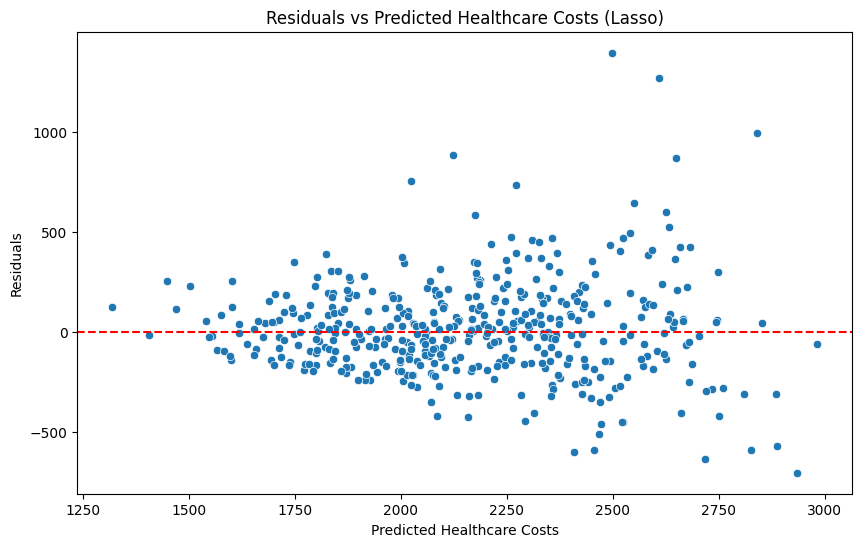

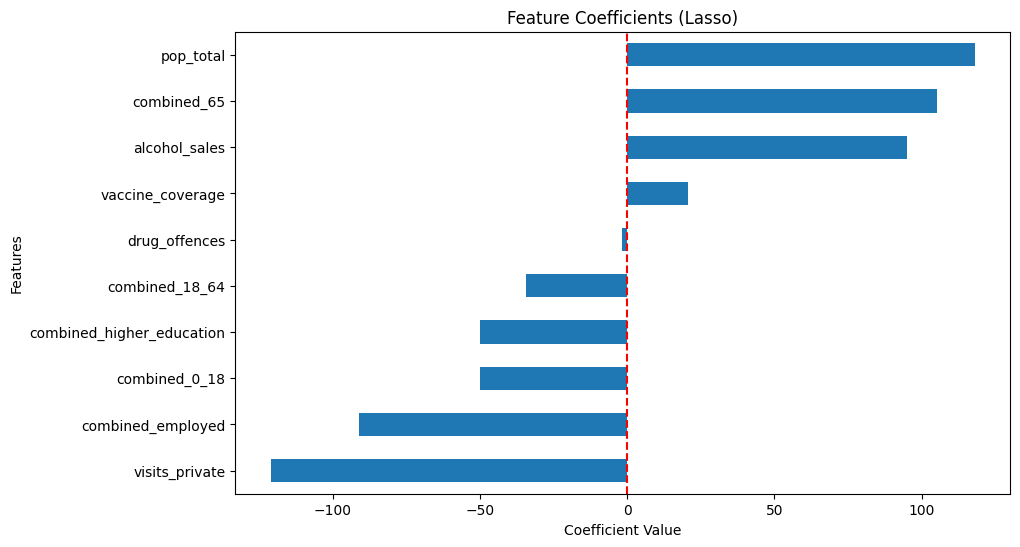

In [455]:
# Visualize the results of the Lasso regression model
# 1. Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Predicted vs Actual Healthcare Costs (Lasso)')
plt.xlabel('Actual Healthcare Costs')
plt.ylabel('Predicted Healthcare Costs')
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Healthcare Costs (Lasso)')
plt.xlabel('Predicted Healthcare Costs')
plt.ylabel('Residuals')
plt.show()

# 3. Coefficient Plot
# Coefficients of the selected features
coefficients = pd.Series(lasso_cv.coef_, index=numerical_features)
non_zero_coefficients = coefficients[coefficients != 0]
plt.figure(figsize=(10, 6))
non_zero_coefficients.sort_values().plot(kind="barh")
plt.title("Feature Coefficients (Lasso)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.axvline(0, color='red', linestyle='--')
plt.show()



Compared Lasso and OLS regression model, there are no significant differences in MSE and R-squared. We can see simliar predited results and feature coeffients, and the two models' R-squared approximates 0.62.

### PCR

Lastly, we test a Principal Component regression. 

In [458]:
df = pd.read_csv("data/data_clean.csv")[predictors]

X = df.iloc[:, :-1]
y = df['health_cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Add a constant to the model (intercept) for both training and test sets
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Predictions
y_pred = results.predict(X_test_sm)

mse = np.mean(np.subtract(y_pred, y) ** 2)
print(f"Mean squared error {mse}")

# Print out the statistics
print(results.summary())

Mean squared error 59345.432944524146
                            OLS Regression Results                            
Dep. Variable:            health_cost   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     297.8
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:48:05   Log-Likelihood:                -12259.
No. Observations:                1774   AIC:                         2.454e+04
Df Residuals:                    1763   BIC:                         2.460e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [457]:
df = pd.read_csv("data/data_clean.csv").iloc[:, 2:]

feature_values = df.iloc[:, :-1].values

# Scale features
scaler = StandardScaler()
feature_values = StandardScaler().fit_transform(feature_values)

# perform PCA and take the components as predictors
pca = PCA(n_components=7)
principal_components = pca.fit_transform(feature_values)

principal_df = pd.DataFrame(data=principal_components, columns = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7'])
principal_df = pd.concat([principal_df, df[['health_cost']]], axis = 1)

X = principal_df.iloc[:, 0:7]
y = principal_df['health_cost']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Add a constant to the model (intercept) for both training and test sets
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Predictions
y_pred = results.predict(X_test_sm)

mse = np.mean(np.subtract(y_pred, y) ** 2)
print(f"Mean squared error {mse}")

# Print out the statistics
print(results.summary())

Mean squared error 59861.21574163573
                            OLS Regression Results                            
Dep. Variable:            health_cost   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     426.8
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:41:58   Log-Likelihood:                -12259.
No. Observations:                1774   AIC:                         2.453e+04
Df Residuals:                    1766   BIC:                         2.458e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       218

## Results

# Conclusion

Total population, alcohol sales, the proportion of people over 65 years old, and flu vaccine coverage have positive influences on healthcare expenditures, while education level, employment, and private healthcare visits have negative influences on healthcare costs.  

Therefore, the government can reduce healthcare expenditures by controlling the sale of alcohol and the elderly population, reducing the number of unemployed people, as well as increasing the level of education and encouraging private healthcare visits. At the same time, people should also realize that drinking less alcohol, studying more, and enjoy their work can be beneficial to health.

We have distributed the model as a web page that has been deployed to Heroku servers. The address is 